<a href="https://colab.research.google.com/github/alaajomah/ML/blob/main/own_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras import applications

import tensorflow as tf
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

In [65]:
# Get the Horse or Human training dataset

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [66]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Sample horse image:


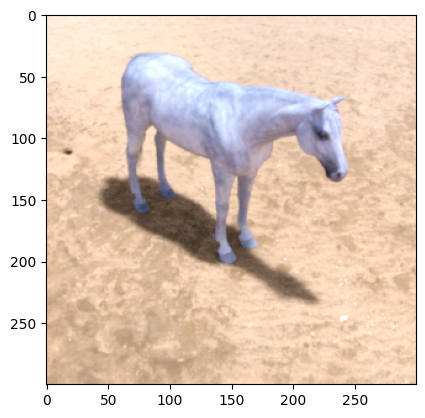


Sample human image:


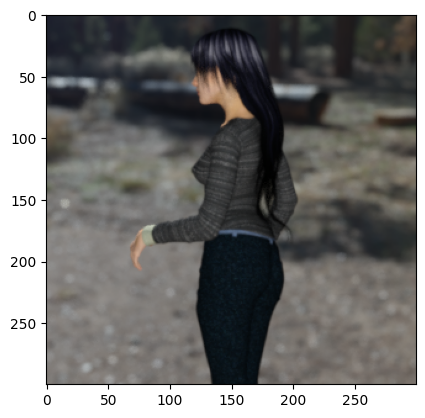

In [67]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [68]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


In [69]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
   # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen =  ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [70]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [71]:
# Import the inception model
from tensorflow.keras.applications.resnet50 import ResNet50

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels'

In [75]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = ResNet50(include_top=True,weights='imagenet')
  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model


In [79]:
model=applications.ResNet50(include_top=True,weights='imagenet')


In [80]:


# Print the model summary
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_16[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [81]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [82]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [83]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output

In [84]:
last_output = output_of_last_layer(pre_trained_model)


last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [85]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [86]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = tf.nn.relu)(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation = tf.nn.sigmoid)(x)

  # Create the complete model by using the Model class
  model = Model(pre_trained_model.input, x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

  ### END CODE HERE

  return model

In [87]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [89]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
17/17 - 85s - loss: 0.3033 - accuracy: 0.9143 - val_loss: 0.1471 - val_accuracy: 0.9375 - 85s/epoch - 5s/step
Epoch 2/100
17/17 - 80s - loss: 0.0418 - accuracy: 0.9864 - val_loss: 0.1718 - val_accuracy: 0.9141 - 80s/epoch - 5s/step
Epoch 3/100
17/17 - 80s - loss: 0.0607 - accuracy: 0.9757 - val_loss: 0.1918 - val_accuracy: 0.9219 - 80s/epoch - 5s/step
Epoch 4/100
17/17 - 81s - loss: 0.0243 - accuracy: 0.9912 - val_loss: 0.0555 - val_accuracy: 0.9844 - 81s/epoch - 5s/step
Epoch 5/100
17/17 - 80s - loss: 0.0117 - accuracy: 0.9971 - val_loss: 0.0705 - val_accuracy: 0.9688 - 80s/epoch - 5s/step
Epoch 6/100
17/17 - 79s - loss: 0.0131 - accuracy: 0.9971 - val_loss: 0.2014 - val_accuracy: 0.9141 - 79s/epoch - 5s/step
Epoch 7/100
17/17 - 71s - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0396 - val_accuracy: 0.9883 - 71s/epoch - 4s/step
Epoch 8/100

Reached 99.9% accuracy so cancelling training!
17/17 - 81s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0253 - val_accuracy: 0.988

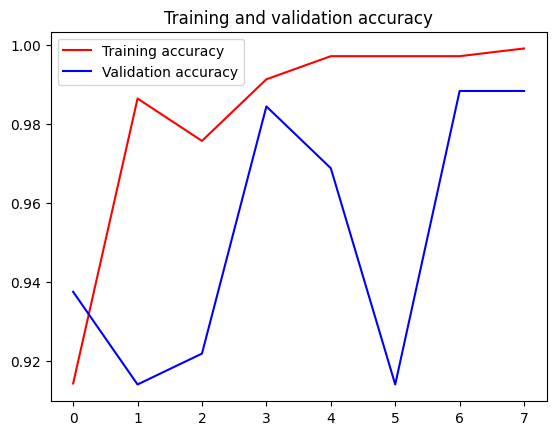

<Figure size 640x480 with 0 Axes>

In [90]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()